## Lab #4


In today's lab we'll extend what we've learned so far on CNNs: 

    1. We'll go from binary to categorical prediction
    2. Use data augmentation
    3. Load homework 2 data and build a basic CNN


We will be using the CIFAR-10 dataset collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. It consists of 60,000 32x32 color images in 10 classes, with 6000 images per class. There are 50,000 training images and 10,000 test images.

The test batch contains exactly 1,000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. See https://www.cs.toronto.edu/~kriz/cifar.html for more information.

Let's import the libraries we'll use:

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, layers, models

### Read in the data
The CIFAR-10 dataset is one of the datasets included in keras. After reading in the data we have to normalize the pixels (divide by 255) and one-hot encode the labels to convert them from a scalar to a vector of length 10.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

### Look at example images

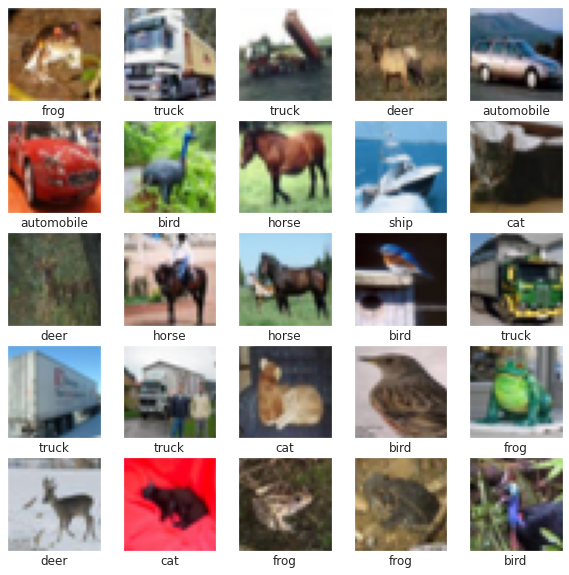

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [ ]:
# Print the shape of the training images
print('X_train shape:', train_images.shape)
print(train_images.shape[0], 'training samples')
print(test_images.shape[0], 'validation samples')

train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Print the shape of the training labels
print('y_train shape:', train_labels.shape)

X_train shape: (50000, 32, 32, 3)
50000 training samples
10000 validation samples
y_train shape: (50000, 10)


### Define a simple CNN
Let's first define a simple CNN like you did in lab last week, without any data augmentation. 

Build a network with 3 `Conv2D` layers with 32, 64 and 64 3x3 filters respectively and `relu` activation function. Add a `MaxPooling2D` layer after the first 2 `Conv2d` layers (but not the third) with a pool size of 2 and stride of 2. Then add a `Flatten` layer followed by a `Dense` layer with 64 nodes and `relu` activation function. Finally, add an appropriate output layer.

Why do you think we excluded a polling layer after the third convolutional layer?
- The dimension of the output after the second pooling layer is 4x4. Adding another pooling layer after the thrid convolutional layer would shrink the output to 2x2 and a loss of information. 4x4 is still small (our original images are small to begin with), but it will perform much better than a 2x2 output. In short, a third pooling layer would shrink the output too much and hinder performance

In [ ]:
# Define model
model = keras.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape = (32, 32, 3)),
  layers.MaxPooling2D((2, 2)),

  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),

  layers.Conv2D(64, (3, 3), activation='relu'),

  layers.Flatten(),

  layers.Dense(64, activation='relu'),

  layers.Dense(10, activation = 'softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(),
              metrics = ['accuracy'])

In [ ]:
history = model.fit(train_images, 
                    train_labels, 
                    epochs = 30,
                    batch_size = 32,
                    validation_data=(test_images, test_labels))

Epoch 1/30
1563/1563 [==============================] - 40s 5ms/step - loss: 1.7869 - accuracy: 0.3446 - val_loss: 1.4400 - val_accuracy: 0.4971
Epoch 2/30
1563/1563 [==============================] - 7s 4ms/step - loss: 1.1679 - accuracy: 0.5871 - val_loss: 1.1320 - val_accuracy: 0.6164
Epoch 3/30
1563/1563 [==============================] - 7s 4ms/step - loss: 0.9635 - accuracy: 0.6609 - val_loss: 1.0554 - val_accuracy: 0.6297
Epoch 4/30
1563/1563 [==============================] - 7s 4ms/step - loss: 0.8569 - accuracy: 0.7008 - val_loss: 0.8961 - val_accuracy: 0.6866
Epoch 5/30
1563/1563 [==============================] - 7s 4ms/step - loss: 0.7696 - accuracy: 0.7288 - val_loss: 0.9913 - val_accuracy: 0.6631
Epoch 6/30
1563/1563 [==============================] - 7s 4ms/step - loss: 0.7008 - accuracy: 0.7577 - val_loss: 0.9159 - val_accuracy: 0.6998
Epoch 7/30
1563/1563 [==============================] - 7s 4ms/step - loss: 0.6540 - accuracy: 0.7711 - val_loss: 0.8673 - val_accuracy

Plot the training and validation accuracy and loss. 

In [ ]:
import seaborn as sns
sns.set()

train_acc  = history.history['accuracy']
train_loss = history.history['loss']
val_acc  = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

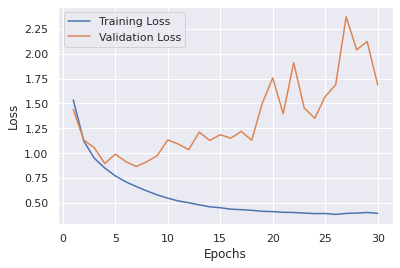

In [ ]:
plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

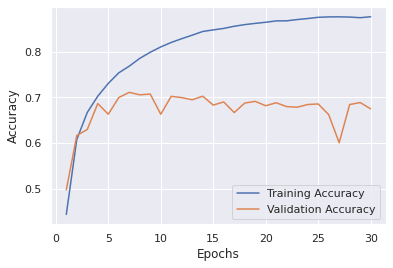

In [ ]:
plt.plot(epochs, train_acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Is there evidence of overfitting?
- Yes. The validation loss reaches a minimum and starts to increase around epoch 9.

## Data Augmentation
Using the same network architecture, train the model using data augmentation. You are free to choose any type(s) and values of augmentation, i.e., `horizontal_flip`, `width_shift_range`, etc. for the `ImageGenerator` function.

In [ ]:
# Define image generator
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
      rotation_range = 60,
      width_shift_range = 0.1,
      height_shift_range = 0.2,
      shear_range = 0.3,
      zoom_range = 0.2,
      horizontal_flip = True,
      fill_mode = 'nearest')

Let's look at a few augmented images.

Number of images returned by iterator: 15


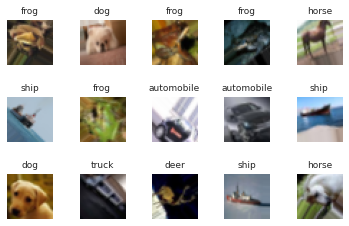

In [ ]:
datagen.fit(train_images)

# This is a Python iterator
it = datagen.flow(train_images, 
                  train_labels, 
                  batch_size = 15)

images, categories = it.next()
print("Number of images returned by iterator:", len(images))
for i in range(15):
    plt.subplot(3, 5, i+1)
    im = images[i]
    c = np.where(categories[i] == 1)[0][0] # convert one-hot to regular index
    plt.imshow(im, cmap='gnuplot2')
    plt.title(class_names[c], fontsize=9)
    plt.axis('off')
    plt.subplots_adjust(wspace=0.6, hspace=0.2)

We aren't reading in images from a folder for this example, so we use the following code to augment our training images.

In [ ]:
train_generator = datagen.flow(train_images, 
                               train_labels, 
                               batch_size=32)

validation_generator = datagen.flow(test_images, 
                                    test_labels, 
                                    batch_size=32)

Now we can train the network and compare performance.

In [ ]:
# Fit the model on the batches generated by datagen.flow().
history2 = model.fit(train_generator,
                     steps_per_epoch = len(train_images) / 32, #2000, # With data augmentation can have more training images 
                     epochs = 30,
                     validation_data = validation_generator,
                     validation_steps = len(test_images) / 32)

Epoch 1/30
1562/1562 [==============================] - 33s 21ms/step - loss: 1.6069 - accuracy: 0.4209 - val_loss: 1.5113 - val_accuracy: 0.4516
Epoch 2/30
1562/1562 [==============================] - 33s 21ms/step - loss: 1.5035 - accuracy: 0.4593 - val_loss: 1.4301 - val_accuracy: 0.4869
Epoch 3/30
1562/1562 [==============================] - 33s 21ms/step - loss: 1.4339 - accuracy: 0.4894 - val_loss: 1.3747 - val_accuracy: 0.5055
Epoch 4/30
1562/1562 [==============================] - 33s 21ms/step - loss: 1.3912 - accuracy: 0.5056 - val_loss: 1.3275 - val_accuracy: 0.5294
Epoch 5/30
1562/1562 [==============================] - 34s 22ms/step - loss: 1.3505 - accuracy: 0.5198 - val_loss: 1.3265 - val_accuracy: 0.5254
Epoch 6/30
1562/1562 [==============================] - 34s 22ms/step - loss: 1.3374 - accuracy: 0.5281 - val_loss: 1.3609 - val_accuracy: 0.5176
Epoch 7/30
1562/1562 [==============================] - 34s 22ms/step - loss: 1.3221 - accuracy: 0.5348 - val_loss: 1.2813 -

Plot the training and validation accuracy and loss for this new model. Then plot the training and validation accuracy for both models on the same plot.
Did data augmentation help with overfitting?
- Yes. The validation loss follows the training loss much more closely.

In [ ]:
train_acc2  = history2.history['accuracy']
train_loss2 = history2.history['loss']
val_acc2  = history2.history['val_accuracy']
val_loss2 = history2.history['val_loss']

epochs = range(1, len(train_acc2) + 1)

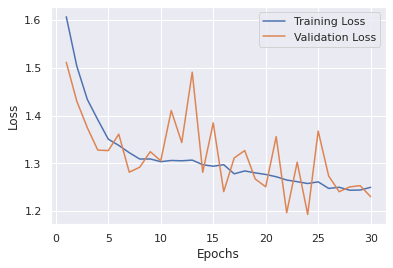

In [ ]:
plt.plot(epochs, train_loss2, label = 'Training Loss')
plt.plot(epochs, val_loss2, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

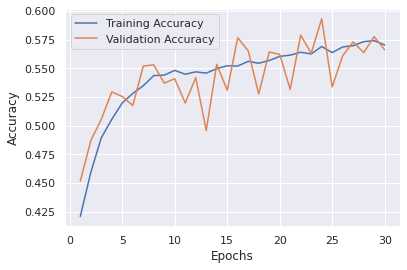

In [ ]:
plt.plot(epochs, train_acc2, label = 'Training Accuracy')
plt.plot(epochs, val_acc2, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

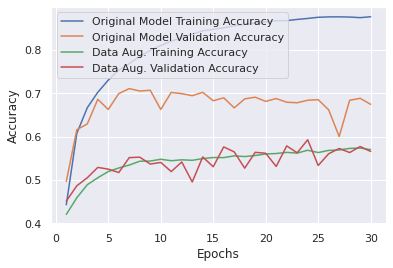

In [ ]:
plt.plot(epochs, train_acc, label = 'Original Model Training Accuracy')
plt.plot(epochs, val_acc, label = 'Original Model Validation Accuracy')
plt.plot(epochs, train_acc2, label = 'Data Aug. Training Accuracy')
plt.plot(epochs, val_acc2, label = 'Data Aug. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## Problem Set 2 help
We'll show you how to read in the dataset needed for Problem Set 2 and how to build a simple CNN.

### Load the data

The data are available in Google Drive [here](https://drive.google.com/open?id=1Q9DGe2-WcN1T5ToDLr4AMk-UAFedb309) or in Dropbox [here](https://www.dropbox.com/sh/6rstxss79669361/AABXuOWEA75MtWWTVeER4UeKa?dl=0).

Load the data and print the number of training, validation and test set examples there are of each class. Be sure to change the directory path provided below to your own data path.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define directories of where the training, validation and test sets reside
# Heather's: 
base_dir = 'drive/My Drive/Teaching/BST 261/2020/Colab Notebooks/In-class examples/Data/xrays/'
# This is the path to where my files are - your path will be different, something like this:
# base_dir = 'drive/My Drive/xrays/'

In [ ]:
train_dir = os.path.join(base_dir, 'train_dir')
validation_dir = os.path.join(base_dir, 'validation_dir')
test_dir = os.path.join(base_dir, 'test_dir')

# Training Data
train_atelectasis  = os.path.join(train_dir, 'atelectasis')
train_effusion     = os.path.join(train_dir, 'effusion')
train_infiltration = os.path.join(train_dir, 'infiltration')
train_mass         = os.path.join(train_dir, 'mass')
train_nodule       = os.path.join(train_dir, 'nodule')
train_none         = os.path.join(train_dir, 'none')
train_pneumothorax = os.path.join(train_dir, 'pneumothorax')

# Validation Data
val_atelectasis  = os.path.join(validation_dir, 'atelectasis')
val_effusion     = os.path.join(validation_dir, 'effusion')
val_infiltration = os.path.join(validation_dir, 'infiltration')
val_mass         = os.path.join(validation_dir, 'mass')
val_nodule       = os.path.join(validation_dir, 'nodule')
val_none         = os.path.join(validation_dir, 'none')
val_pneumothorax = os.path.join(validation_dir, 'pneumothorax')

# Test Data
test_atelectasis  = os.path.join(test_dir, 'atelectasis')
test_effusion     = os.path.join(test_dir, 'effusion')
test_infiltration = os.path.join(test_dir, 'infiltration')
test_mass         = os.path.join(test_dir, 'mass')
test_nodule       = os.path.join(test_dir, 'nodule')
test_none         = os.path.join(test_dir, 'none')
test_pneumothorax = os.path.join(test_dir, 'pneumothorax')

In [ ]:
print('Total training atelectasisat images:', len(os.listdir(train_atelectasis)))
print('Total training effusion images:', len(os.listdir(train_effusion)))
print('Total training infiltration images:', len(os.listdir(train_infiltration)))
print('Total training mass images:', len(os.listdir(train_mass)))
print('Total training nodule images:', len(os.listdir(train_nodule)))
print('Total training no finding images:', len(os.listdir(train_none)))
print('Total training pneumothorax images:', len(os.listdir(train_pneumothorax)))

Total training atelectasisat images: 400
Total training effusion images: 400
Total training infiltration images: 400
Total training mass images: 200
Total training nodule images: 300
Total training no finding images: 400
Total training pneumothorax images: 300


In [ ]:
print('Total validation atelectasisat images:', len(os.listdir(val_atelectasis)))
print('Total validation effusion images:', len(os.listdir(val_effusion)))
print('Total validation infiltration images:', len(os.listdir(val_infiltration)))
print('Total validation mass images:', len(os.listdir(val_mass)))
print('Total validation nodule images:', len(os.listdir(val_nodule)))
print('Total validation no finding images:', len(os.listdir(val_none)))
print('Total validation pneumothorax images:', len(os.listdir(val_pneumothorax)))

Total validation atelectasisat images: 100
Total validation effusion images: 100
Total validation infiltration images: 100
Total validation mass images: 55
Total validation nodule images: 70
Total validation no finding images: 100
Total validation pneumothorax images: 70


In [ ]:
print('Total test atelectasisat images:', len(os.listdir(test_atelectasis)))
print('Total test effusion images:', len(os.listdir(test_effusion)))
print('Total test infiltration images:', len(os.listdir(test_infiltration)))
print('Total test mass images:', len(os.listdir(test_mass)))
print('Total test nodule images:', len(os.listdir(test_nodule)))
print('Total test no finding images:', len(os.listdir(test_none)))
print('Total test pneumothorax images:', len(os.listdir(test_pneumothorax)))

Total test atelectasisat images: 100
Total test effusion images: 100
Total test infiltration images: 100
Total test mass images: 55
Total test nodule images: 70
Total test no finding images: 100
Total test pneumothorax images: 70


Let's take a look at what one of the images looks like.

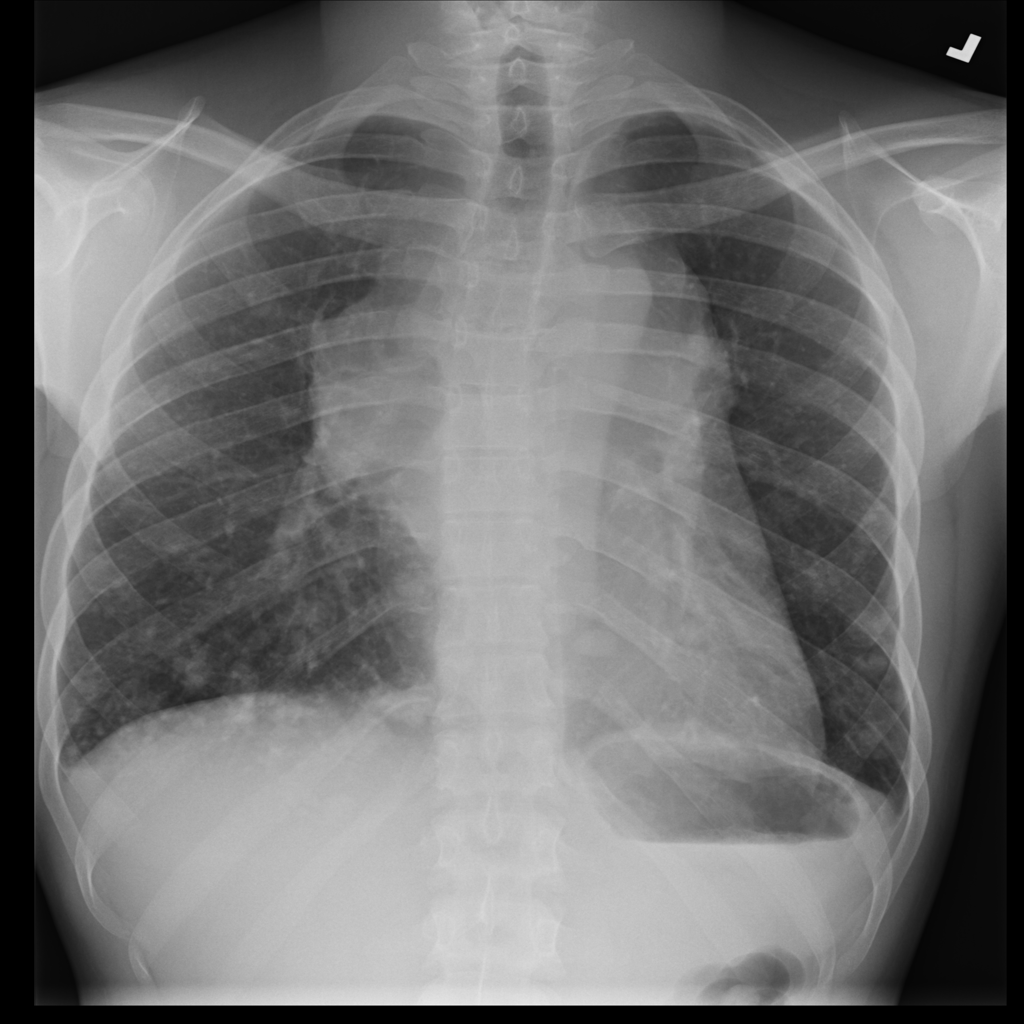

In [ ]:
from IPython.display import Image
Image(filename= train_dir + '/nodule/Nodule_2.png')

### Small CNN
Let's define our data generators first. Then you can build a small CNN.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import math

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size = (64, 64),
        batch_size = batch_size,
        # Since we use categorical_crossentropy loss, we need binary labels
        class_mode = 'categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size = (64, 64),
        batch_size = batch_size,
        class_mode = 'categorical')

Found 2400 images belonging to 7 classes.
Found 595 images belonging to 7 classes.


Let's also define the number of samples per epoch for later.

In [ ]:
num_training_samples = math.ceil(2400/batch_size)
num_validation_samples = math.ceil(595/batch_size)

Build a CNN of your choosing! Select the appropriate loss, optimizer, and performance metric. Include a `Dropout` layer to mitigate overfitting.

In [ ]:
# Define model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = (64, 64, 3)),
  tf.keras.layers.MaxPooling2D((2, 2)),

  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),

  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(128, activation='relu'),

  tf.keras.layers.Dense(7, activation = 'softmax')
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 64)         

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(),
              metrics = ['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch = num_training_samples,
                    epochs = 30,
                    validation_data = validation_generator,
                    validation_steps = num_validation_samples)

Epoch 1/30
75/75 [==============================] - 1269s 17s/step - loss: 1.9199 - accuracy: 0.2067 - val_loss: 1.9019 - val_accuracy: 0.2185
Epoch 2/30
75/75 [==============================] - 47s 625ms/step - loss: 1.8249 - accuracy: 0.2713 - val_loss: 1.8825 - val_accuracy: 0.2605
Epoch 3/30
75/75 [==============================] - 47s 621ms/step - loss: 1.7899 - accuracy: 0.2904 - val_loss: 1.8899 - val_accuracy: 0.2521
Epoch 4/30
75/75 [==============================] - 47s 622ms/step - loss: 1.7401 - accuracy: 0.3192 - val_loss: 1.9362 - val_accuracy: 0.2437
Epoch 5/30
75/75 [==============================] - 47s 620ms/step - loss: 1.7219 - accuracy: 0.3221 - val_loss: 1.8904 - val_accuracy: 0.2555
Epoch 6/30
75/75 [==============================] - 46s 619ms/step - loss: 1.6975 - accuracy: 0.3354 - val_loss: 1.9608 - val_accuracy: 0.2370
Epoch 7/30
75/75 [==============================] - 47s 628ms/step - loss: 1.6589 - accuracy: 0.3512 - val_loss: 1.9495 - val_accuracy: 0.2723

Plot the training and validation loss and accuracy. Comment on the performance of the model.

In [ ]:
train_acc  = history.history['accuracy']
train_loss = history.history['loss']
val_acc  = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

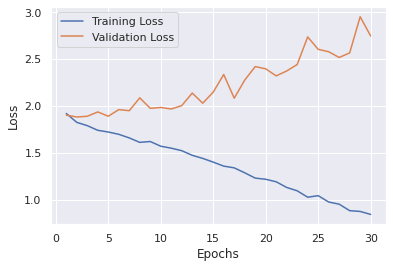

In [ ]:
plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

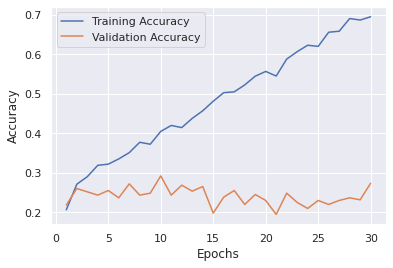

In [ ]:
plt.plot(epochs, train_acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

The performance is pretty low. This is due to not having enough training data for each of the 7 classes. You'll try to increase the performance of your network using data augmentation and a pretrained base in Problem Set 2.